In [1]:
import numpy as np
from scipy.ndimage import binary_erosion
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import Planck18
from astropy import units as u
from pdet import *
import os

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("default")
plt.style.use("mainstyle.mplstyle")

save_fig = True
image_path = "paper/images"

figures, figure_paths = [], []

In [3]:
# Labels strings
msun_lb = "\mathrm{M}_\odot"
Gpc_lb = "\mathrm{Gpc}"
yr_lb = "\mathrm{yr}"
pdet_lb = "p_\\text{det}"
VT_lb = "\left\langle VT\\right\\rangle"
Tobs_lb = "T_\\text{obs}"
Vcshell_lb = "V_{c,\\text{shl}}"
Nref_lb = "N_\\text{ref}"
zt_lb = "z_t"
zref_lb = "z_\\text{ref}"
Nratio_lb = "N_t / N_\\text{ref}"
Rratio_lb = "\mathcal{R}_t / \mathcal{R}_\\text{ref}"
lowm_lb = "low mass bin"
high_lb = "high mass bin"

In [4]:
Tobs = 1 # yr

m1_min, m1_max, m1_w = 1, 100, 1
z_min, z_max, z_w = 0, 10, 0.1
q_list = [0.2, 0.4, 0.6, 0.8, 1] # q=1 in last place

m1 = np.arange(m1_min, m1_max + m1_w, m1_w)
m2_list = [m1 * q for q in q_list]
z = np.arange(z_min, z_max + z_w, z_w)

In [5]:
p_det_qlist = [np.zeros((len(z), len(m1))) for q in q_list] # q=1 in last place

for i, _m2 in enumerate(m2_list):
    for j, _z in enumerate(z):
        p_det_qlist[i][j] = p(m1, _m2, np.zeros(len(m1)) + _z)

In [6]:
# q_list index for which the plots should be made
q_index = -1

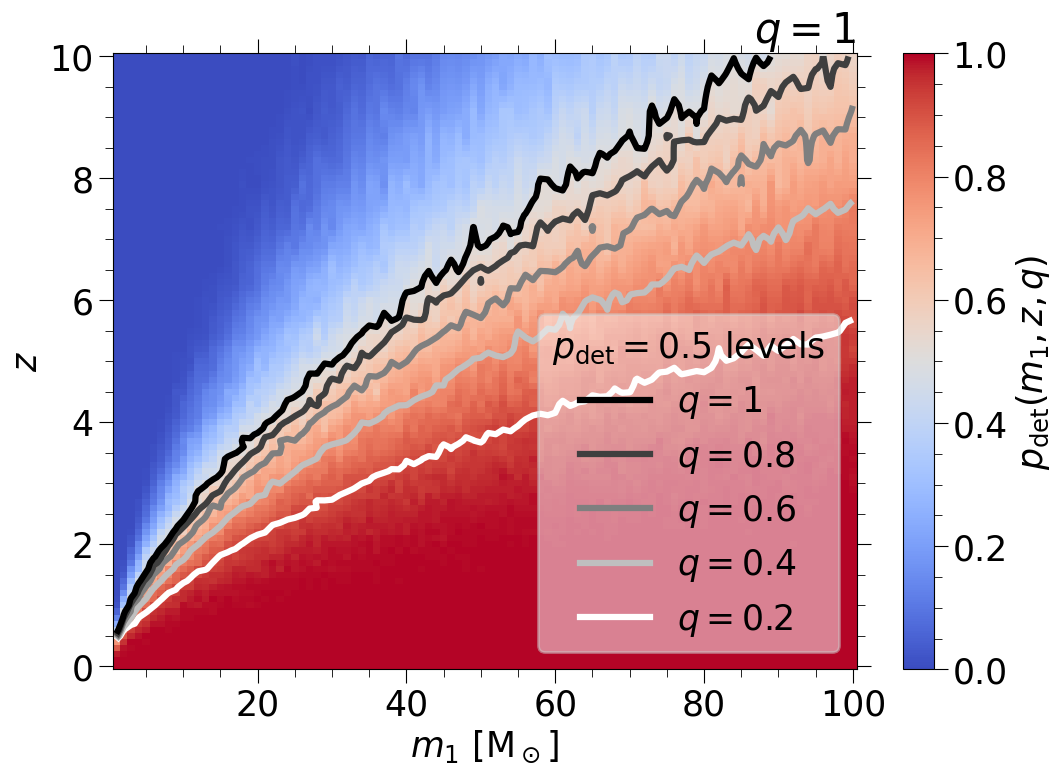

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(rf'$q = {q_list[q_index]}$', loc='right')

ax.set_xlabel(rf'$m_1\ [{msun_lb}]$')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['coolwarm']
im = ax.pcolormesh(m1, z, p_det_qlist[q_index], cmap=cmap, vmin=0, vmax=1)

fig.colorbar(im, ax=ax, label=rf'${pdet_lb}(m_1, z, q)$')

lines = []
for _q, p_det, c in zip(q_list, p_det_qlist, plt.colormaps['binary'](np.linspace(0, 1, len(q_list)))):
    cf = ax.contour(m1, z, p_det, levels=[0.5], colors=c)
    lines.append(ax.plot([], [], color=c, label=rf'$q = {_q}$')[0]) # Proxy for legend

ax.legend(handles=lines, loc='lower right',
          reverse=True, title=rf'${pdet_lb} = 0.5$ levels')

figures.append(fig)
figure_paths.append(os.path.join(image_path, "pdet_map"))

plt.show()

In [8]:
if __name__ == '__main__':
    VT = VT_pop_uniform_q(Tobs, z, m1, q_list[q_index])

Computing VT for each (m, z) pair for a uniformly distributed population of sources with fixed q = 1:   0%|          | 0/9900 [00:00<?, ?it/s]

Computing VT for each (m, z) pair for a uniformly distributed population of sources with fixed q = 1: 100%|██████████| 9900/9900 [01:34<00:00, 104.63it/s]


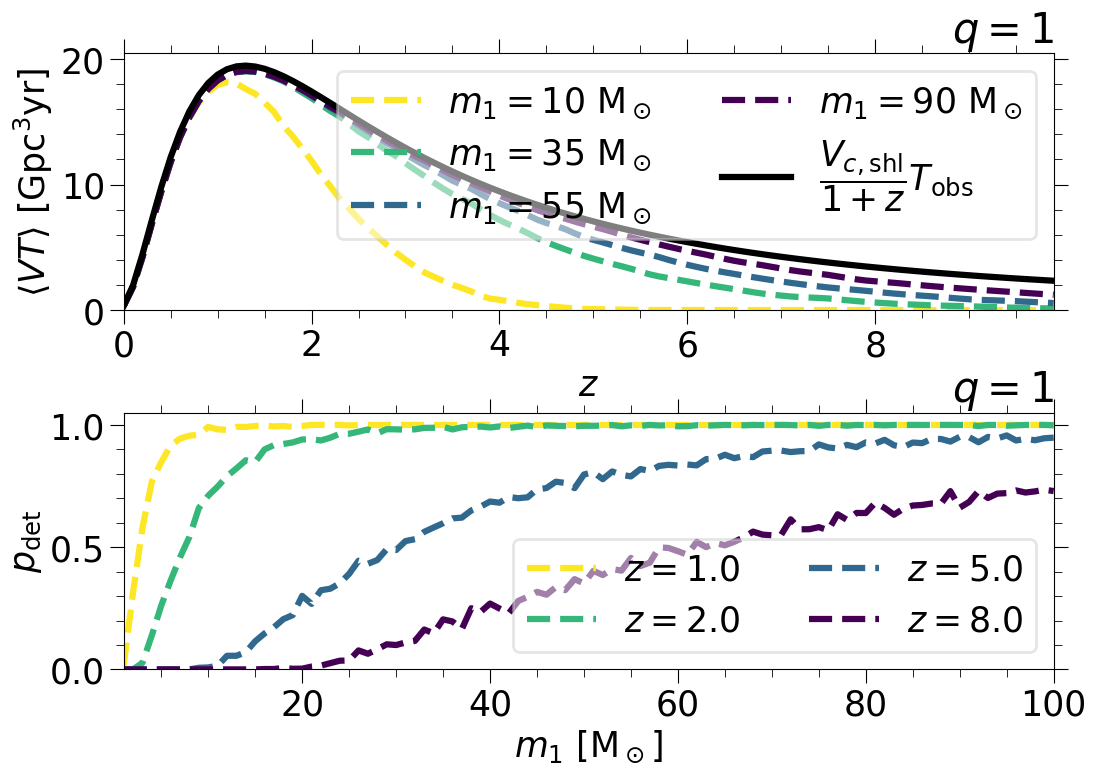

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

VT_plot = VT / 1e9

plt.subplots_adjust(hspace=0.4)

for ax in axes:
    ax.set_title(rf'$q = {q_list[q_index]}$', loc='right')

axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(rf'${VT_lb}\ [{Gpc_lb}^3{yr_lb}]$')

axes[1].set_xlabel(rf'$m_1\ [{msun_lb}]$')
axes[1].set_ylabel(rf'${pdet_lb}$')

indexes = [m1 == val for val in [10, 35, 55, 90]]
for i, mask in enumerate(indexes):
    indexes[i] = np.argwhere(mask)[0][0]
for index, c in zip(indexes, plt.colormaps['viridis_r'](np.linspace(0, 1, len(indexes)))):
    axes[0].plot(z[:-1], VT_plot[:, index], color=c, linestyle='--', label=rf'$m_1 = {m1[index]}\ {msun_lb}$')

cosmology_factor = Tobs * (Planck18.comoving_volume(z[1:]) - Planck18.comoving_volume(z[:-1])).to(u.Gpc ** 3).to_value() / (1 + z[:-1])
axes[0].plot(z[:-1], cosmology_factor, color='black', label=rf'$\dfrac{{{Vcshell_lb}}}{{1+z}} {Tobs_lb}$')

ylims = axes[0].get_ylim()
axes[0].autoscale(axis='both', tight=True)
axes[0].set_ylim(top=ylims[-1])

axes[0].legend(loc='upper right', ncols=2)

indexes = [z == val for val in [1, 2, 5, 8]]
for i, mask in enumerate(indexes):
    indexes[i] = np.argwhere(mask)[0][0]
for index, c in zip(indexes, plt.colormaps['viridis_r'](np.linspace(0, 1, len(indexes)))):
    axes[1].plot(m1, p_det_qlist[q_index][index], color=c, linestyle='--', label=rf'$z = {z[index]}$')

ylims = axes[1].get_ylim()
axes[1].autoscale(axis='both', tight=True)
axes[1].set_ylim(top=ylims[-1])

axes[1].legend(loc='lower right', ncols=2)

figures.append(fig)
figure_paths.append(os.path.join(image_path, "pdet_and_VT_trends"))

plt.show()

In [10]:
m_keys = ("low", "high")

mlb = {key: val for key, val in zip(m_keys, (lowm_lb, high_lb))}
mc = {key: val for key, val in zip(m_keys, (10, 35))}
mw = {key: val for key, val in zip(m_keys, (4, 4))}
q = {key: val for key, val in zip(m_keys, (0.8, 1))}
zw = {key: val for key, val in zip(m_keys, (0.1, 0.1))}
T_obs = {key: val for key, val in zip(m_keys, (Tobs, Tobs))}

zinf_axis = {key: np.arange(zinf_min, zinf_max + zw[key], zw[key]) for key, zinf_min, zinf_max in zip(m_keys, (0, 0), (10, 10))}

bins_axis = {key: [MZQbin(mc[key] - mw[key] / 2,
                          mc[key] + mw[key] / 2,
                          zinf,
                          zinf + zw[key],
                          q[key]) for zinf in zinf_axis[key]] for key in m_keys}

In [11]:
if __name__ == '__main__':
    for key in m_keys:
        bin_initializer(bins_axis[key], T_obs[key])

Initilizing bins: computing VT: 100%|██████████| 101/101 [00:49<00:00,  2.05it/s]


In [12]:
N1_N2_axis_res = 0.02
N1_N2_axis = {key: np.arange(val_min, val_max, N1_N2_axis_res) for key, val_min, val_max in zip(m_keys, (0.01, 0.01), (10, 10))}

zref = {key: val for key, val in zip(m_keys, (0.2, 0.2))} # Reference redshift (inferior limit of reference redshift bin). Choose a value present in zinf_axis
N2_ref = {key: val for key, val in zip(m_keys, (10, 10))}
bin2_ref = {key: MZQbin(mc[key] - mw[key] / 2, mc[key] + mw[key] / 2, zref[key], zref[key] + zw[key], q[key]) for key in m_keys}

cl = 0.95

for key in m_keys:
    bin2_ref[key].VTmc(T_obs[key])

In [13]:
R1_R2_CI_map = {key: RateRatioBayesCI_map(cl, bin2_ref[key], N1_N2_axis[key], bins_axis[key], N2_ref[key], T_obs[key]) for key in m_keys}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Feder

In [14]:
R1_R2_CI_array = {key: np.zeros((len(N1_N2_axis[key]), len(bins_axis[key]), 3)) for key in m_keys}
R1_R2_a_array = {key: np.zeros((len(N1_N2_axis[key]), len(bins_axis[key]))) for key in m_keys}

R1_R2_ref = 1

R1_R2_ref_list = [0.01, 0.1, 0.5, 1, 2, 3, 5, 10, 100, 1000]
# Linked to R1_R2_ref_list on the first dimension. True if the corresponding R1_R2 value is inside the confidence interval
R1_R2_CI_list_mask = {key: np.zeros((len(R1_R2_ref_list), len(N1_N2_axis[key]), len(bins_axis[key])), dtype=bool) for key in m_keys}
Det_map_R1_R2_list = {key: [None for R1_R2 in R1_R2_ref_list] for key in m_keys}


# Fill the arrays
for key in m_keys:
    for i, _ in enumerate(N1_N2_axis[key]):
        for j, _ in enumerate(bins_axis[key]):
            R1_R2_CI_array[key][i, j] = np.copy(R1_R2_CI_map[key][i][j][0])
            R1_R2_a_array[key][i, j] = R1_R2_CI_map[key][i][j][2] # a = bin2_ref.VT / bin.VT
    
    for i, R1_R2 in enumerate(R1_R2_ref_list):
        R1_R2_CI_list_mask[key][i] = (R1_R2_CI_array[key][:, :, 0] <= R1_R2) & (R1_R2 <= R1_R2_CI_array[key][:, :, 2])

    for i, R1_R2 in enumerate(R1_R2_ref_list):
        Det_map_R1_R2_list[key][i] = ((R1_R2_CI_array[key][:, :, 0] <= R1_R2) & (R1_R2 <= R1_R2_CI_array[key][:, :, 2]))
        Det_map_R1_R2_list[key][i] = np.ma.masked_array(Det_map_R1_R2_list[key][i], ~Det_map_R1_R2_list[key][i]).astype(int)

# For each value in R1_R2_ref_list, select the N1_N2 vs z curves that represents the associated confidence interval
inf_lvl_alpha = {key: np.zeros((len(R1_R2_ref_list), len(bins_axis[key]))) for key in m_keys}
sup_lvl_alpha = {key: np.zeros((len(R1_R2_ref_list), len(bins_axis[key]))) for key in m_keys}

for key in m_keys:
    for i in range(len(R1_R2_ref_list)):
        for j in range(len(bins_axis[key])):
            True_indexes = np.where(R1_R2_CI_list_mask[key][i, :, j])[0]
            if len(True_indexes) != 0:
                inf_lvl_alpha[key][i, j] = N1_N2_axis[key][True_indexes[0]]
                sup_lvl_alpha[key][i, j] = N1_N2_axis[key][True_indexes[-1]]

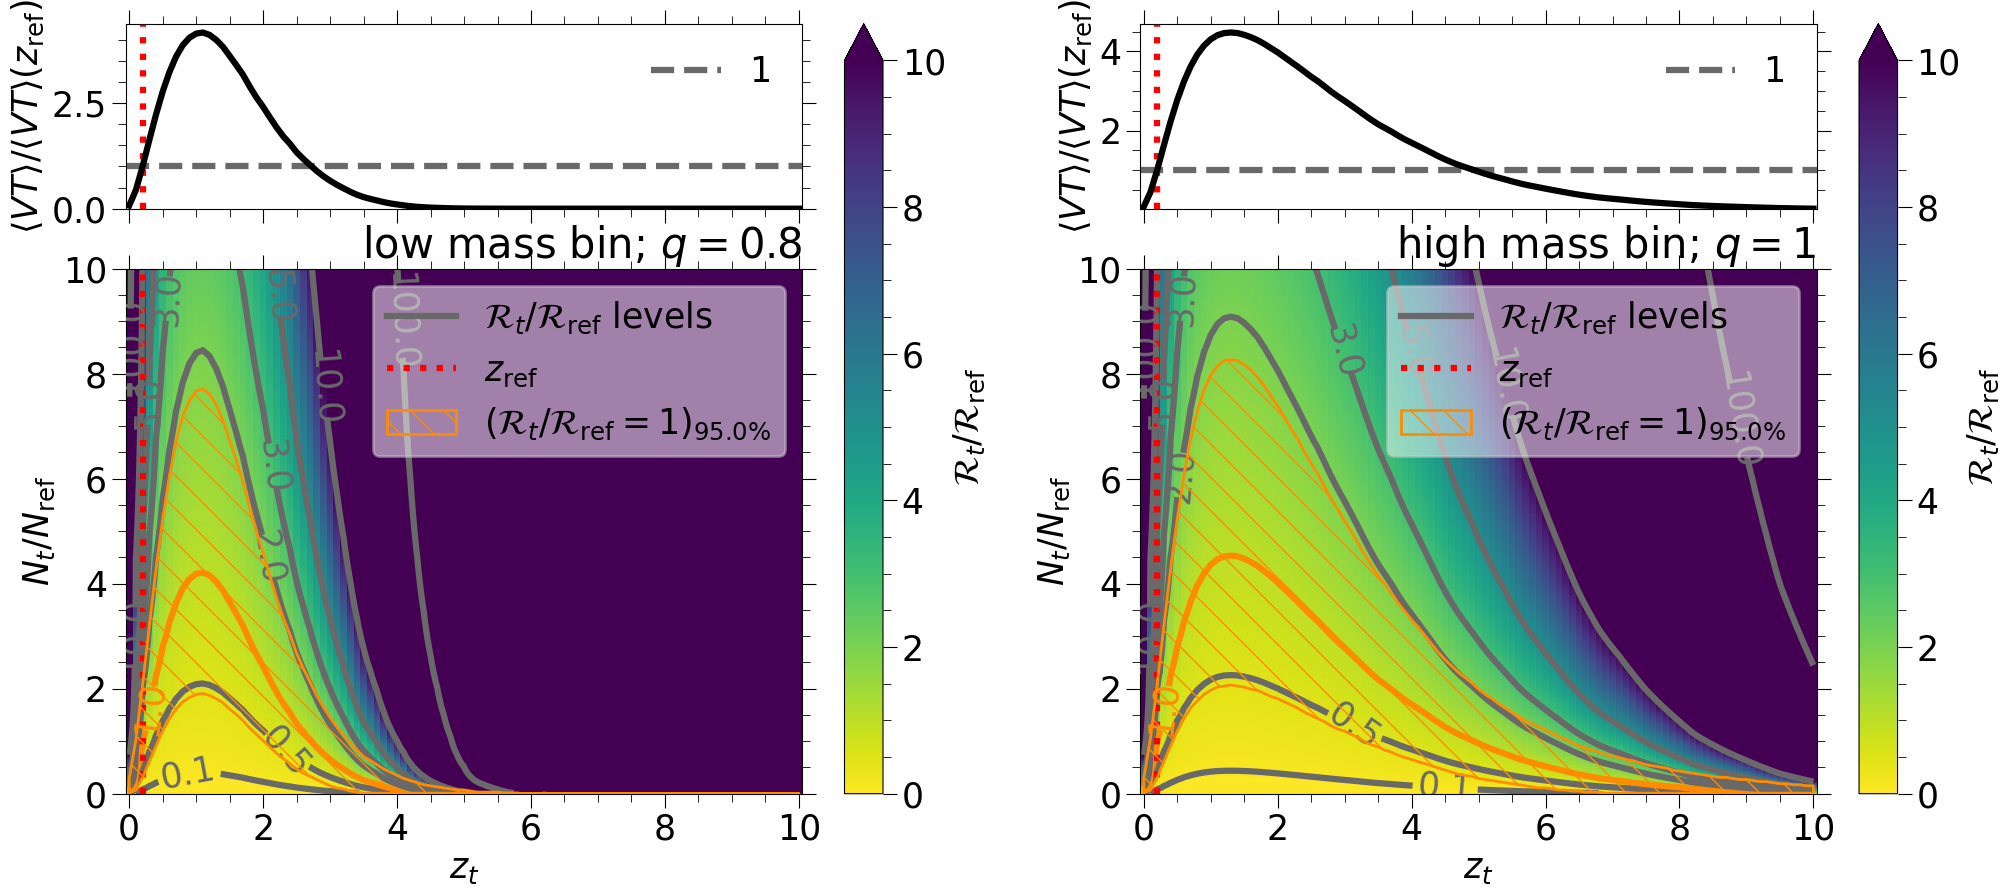

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    data_plot = np.copy(R1_R2_CI_array[key])
    data_plot[np.isinf(data_plot)] = 1e9 # Map infinite values to high numbers to avoid empty regions in the plot

    divider = make_axes_locatable(ax)

    ax_top = divider.append_axes('top', 1.85, pad=0.6, sharex=ax)
    ax_top.tick_params(labelbottom=False)
    
    ax.set_title(rf'{mlb[key]}; $q = {q[key]}$', loc='right')

    ax.set_xlabel(rf'${zt_lb}$')
    ax.set_ylabel(rf'${Nratio_lb}$')
    ax_top.set_ylabel(rf'${VT_lb} / {VT_lb}({zref_lb})$')
    # ax_top.set_ylabel(rf'$\dfrac{{{VT_lb}}}{{{VT_lb}({zref_lb})}}$')
    ax_top.set_ylabel(rf'${VT_lb} / {VT_lb}({zref_lb})$')

    # R1/R2 color map
    cmap = plt.colormaps['viridis_r']
    im = ax.pcolormesh(zinf_axis[key], N1_N2_axis[key], data_plot[:, :, 1],
                       cmap=cmap, vmin=0, vmax=10)
    fig.colorbar(im, ax=ax, label=rf'${Rratio_lb}$', extend='max')

    lines = []
    # R1/R2 Contour levels
    levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 2, 3, 5, 10, 100, R1_R2_ref])))
    lvl_color, ref_lvl_color = 'dimgray', 'darkorange'
    colors = [lvl_color] * len(levels)
    colors[levels.index(R1_R2_ref)] = ref_lvl_color
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], data_plot[:, :, 1],
                    levels=levels, colors=colors)
    lines.append(ax.plot([], [], color=lvl_color, label=rf'${Rratio_lb}$ levels')[0]) # Proxy for legend
    ax.clabel(cf)

    # Reference line for the reference bin
    lines.append(ax.axvline(bin2_ref[key].zinf, color='red', linestyle=':', label=rf'${zref_lb}$'))
    ax_top.axvline(bin2_ref[key].zinf, color='red', linestyle=':')
    ax_top.axhline(1, color=lvl_color, linestyle='--', label=1)

    # Plot the confidence interval for R2/R2 = 1
    lines.append(ax.fill_between(zinf_axis[key], inf_lvl_alpha[key][R1_R2_ref_list.index(R1_R2_ref)], sup_lvl_alpha[key][R1_R2_ref_list.index(R1_R2_ref)],
                                 color=ref_lvl_color, facecolor='none', hatch='\\',label=rf'$({Rratio_lb} = {R1_R2_ref})_{{{cl * 100}\%}}$', zorder=100))

    ax.legend(handles=lines, loc='upper right')
    ax_top.legend(loc='upper right', frameon=False)

    # Divide by 1e9 to convert to Gpc^3 yr
    VT_zref = bins_axis[key][np.where(zinf_axis[key] == bin2_ref[key].zinf)[0][0]].VT
    ax_top.plot(zinf_axis[key], [bin.VT / VT_zref for bin in bins_axis[key]], color='black')

    ylims = ax_top.get_ylim()
    ax_top.autoscale(axis='both', tight=True)
    ax_top.set_ylim(top=ylims[-1])

figures.append(fig)
figure_paths.append(os.path.join(image_path, "Nratio_zt_map"))

plt.show()

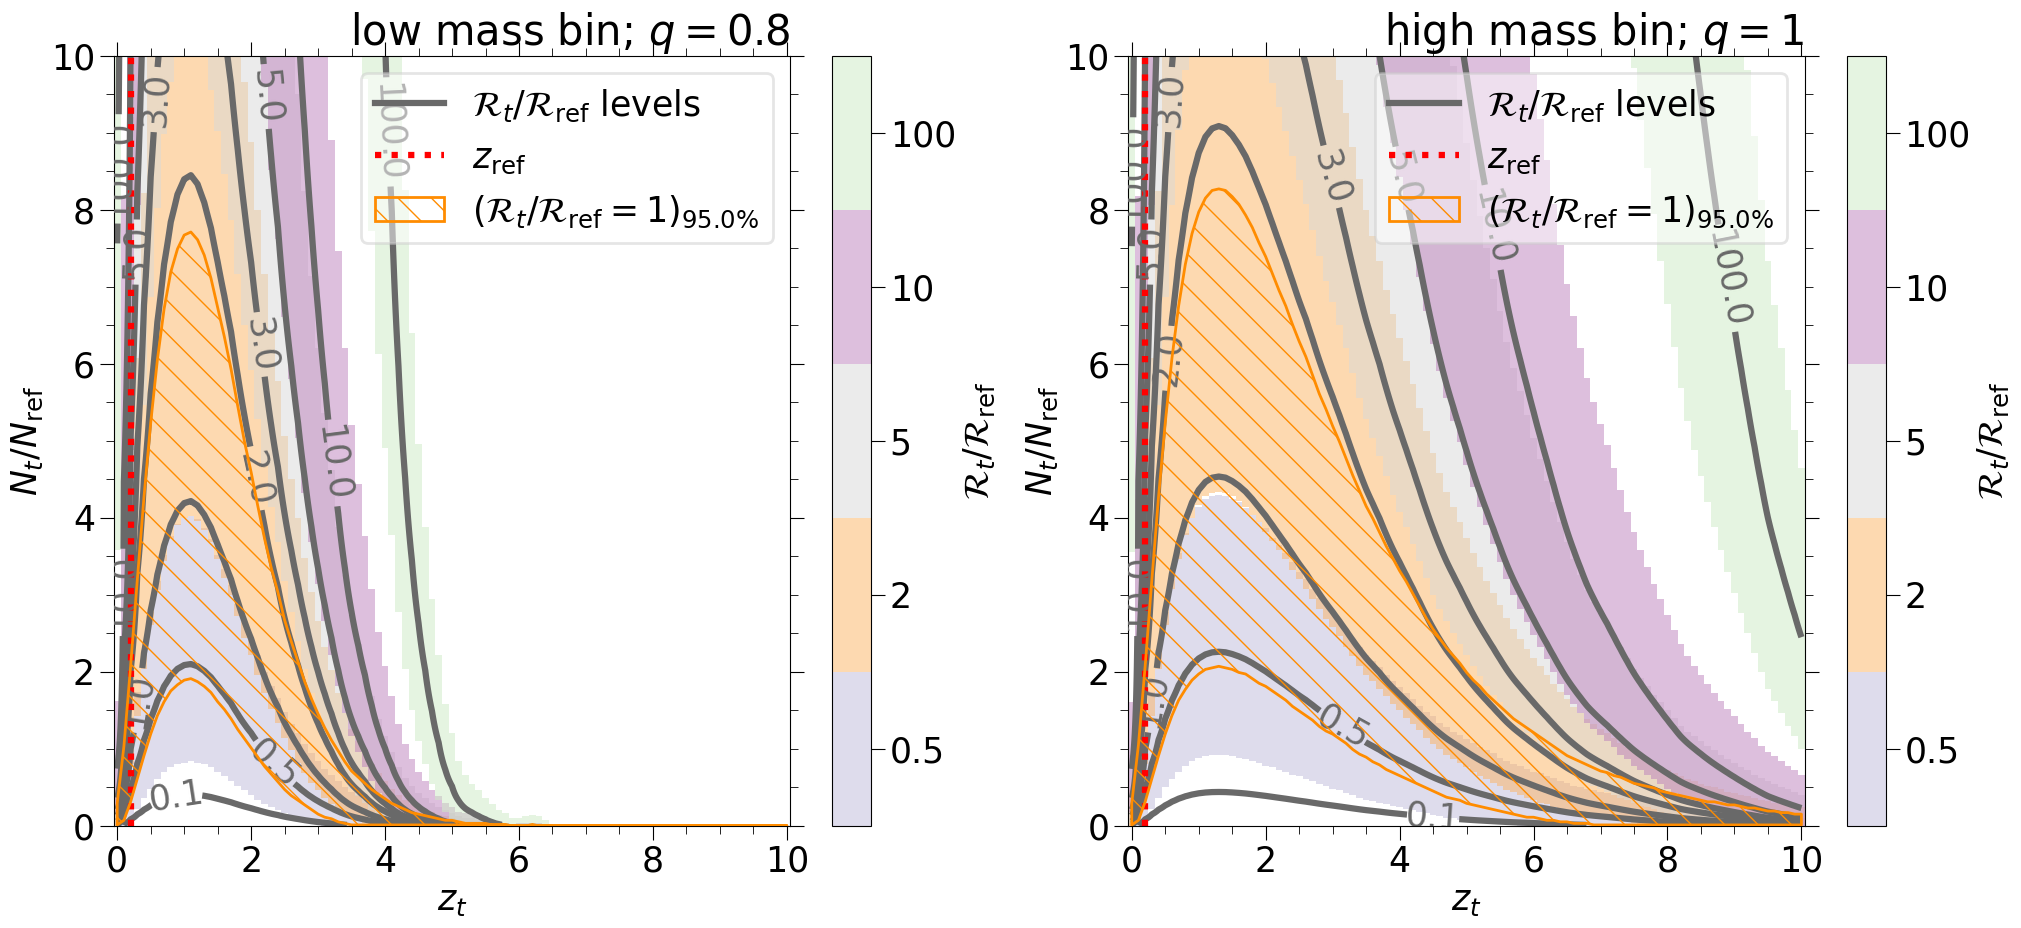

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(rf'{mlb[key]}; $q = {q[key]}$', loc='right')

    ax.set_xlabel(rf'${zt_lb}$')
    ax.set_ylabel(rf'${Nratio_lb}$')

    # R1/R2 color map
    cmap = plt.colormaps['Set3'].resampled(len(R1_R2_ref_list))
    cmap = ListedColormap(cmap.colors)
    _alpha = 0.5

    only_these_R1_R2 = [0.5, 2, 5, 10, 100]
    color_indexes = []
    for i, (Det_map, lb) in enumerate(zip(Det_map_R1_R2_list[key], R1_R2_ref_list)):
        if len(only_these_R1_R2) == 0:
            im = ax.pcolormesh(zinf_axis[key], N1_N2_axis[key], Det_map,
                               cmap=ListedColormap([cmap.colors[i]]), alpha=_alpha)
        elif lb in only_these_R1_R2:
            im = ax.pcolormesh(zinf_axis[key], N1_N2_axis[key], Det_map,
                               cmap=ListedColormap([cmap.colors[i]]), alpha=_alpha)
            color_indexes.append(i)
    
    lines = []
    # R1/R2 Contour levels
    levels = [0.1, 0.5, 1, 2, 3, 5, 10, 100]
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_CI_array[key][:, :, 1],
                    levels=levels, colors=lvl_color)
    lines.append(ax.plot([], [], color=lvl_color, label=rf'${Rratio_lb}$ levels')[0]) # Proxy for legend
    ax.clabel(cf)

    # Reference line for the reference bin
    lines.append(ax.axvline(bin2_ref[key].zinf, color='red', linestyle=':', label=rf'${zref_lb}$'))
    
    # Plot the confidence interval for R2/R2 = 1
    lines.append(ax.fill_between(zinf_axis[key], inf_lvl_alpha[key][R1_R2_ref_list.index(R1_R2_ref)], sup_lvl_alpha[key][R1_R2_ref_list.index(R1_R2_ref)],
                                 color=ref_lvl_color, facecolor='none', hatch='\\', label=rf'$({Rratio_lb} = {R1_R2_ref})_{{{cl * 100}\%}}$', zorder=100))

    # Define the boundaries of each colors using equal spacing
    if len(only_these_R1_R2) == 0:
        boundaries = np.arange(len(R1_R2_ref_list) + 1)
    else:
        boundaries = np.arange(len(only_these_R1_R2) + 1)
        cmap = ListedColormap([cmap.colors[i] for i in color_indexes])
    # Associate to each color bin its color using a BoundaryNorm, the cmap and the ScalarMappable
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
    sm = ScalarMappable(norm, cmap)
    # Define each tick location in the middle of each color bin
    tick_locs = boundaries[:-1] + 0.5
    # Create the colorbar with our cmap and the ticks locations
    cbar = fig.colorbar(sm, ax=ax, label=rf'${Rratio_lb}$', ticks=tick_locs)
    # Now set the labels
    if len(only_these_R1_R2) == 0:
        cbar.ax.get_yaxis().set_ticklabels(labels=R1_R2_ref_list)
    else:
        cbar.ax.get_yaxis().set_ticklabels(labels=only_these_R1_R2)
    cbar.ax.get_yaxis().set_minor_locator(mpl.ticker.NullLocator())
    # This is the only way I found to set the colorbar transparency
    cbar.solids.set_alpha(_alpha)

    ax.legend(handles=lines, loc='upper right')

figures.append(fig)
figure_paths.append(os.path.join(image_path, "Nratio_zt_detmap"))

plt.show()

In [17]:
N1_N2 = 1
R1_R2_CI_ZZmap = {key: RateRatioBayesCI_ZZmap(cl, N1_N2, bins_axis[key], bins_axis[key], N2_ref[key], T_obs[key]) for key in m_keys}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:253: RuntimeWarning: invalid value encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_boun

In [18]:
R1_R2_CI_ZZarray = {key: np.zeros((len(bins_axis[key]), len(bins_axis[key]), 3)) for key in m_keys}
R1_R2_a_ZZarray = {key: np.zeros((len(bins_axis[key]), len(bins_axis[key]))) for key in m_keys}

# Linked to R1_R2_ref_list on the first dimension. True if the corresponding R1_R2 value is inside the confidence interval
Det_ZZmap_R1_R2_list = {key: [None for R1_R2 in R1_R2_ref_list] for key in m_keys}

# Fill the arrays
for key in m_keys:
    for i, _ in enumerate(bins_axis[key]):
        for j, _ in enumerate(bins_axis[key]):
            R1_R2_CI_ZZarray[key][i, j] = np.copy(R1_R2_CI_ZZmap[key][i][j][0])
            R1_R2_a_ZZarray[key][i, j] = R1_R2_CI_ZZmap[key][i][j][2] # a = bin2.VT / bin1.VT

    for i, R1_R2 in enumerate(R1_R2_ref_list):
        Det_ZZmap_R1_R2_list[key][i] = ((R1_R2_CI_ZZarray[key][:, :, 0] <= R1_R2) & (R1_R2 <= R1_R2_CI_ZZarray[key][:, :, 2]))
        Det_ZZmap_R1_R2_list[key][i] = np.ma.masked_array(Det_ZZmap_R1_R2_list[key][i], ~Det_ZZmap_R1_R2_list[key][i]).astype(int)

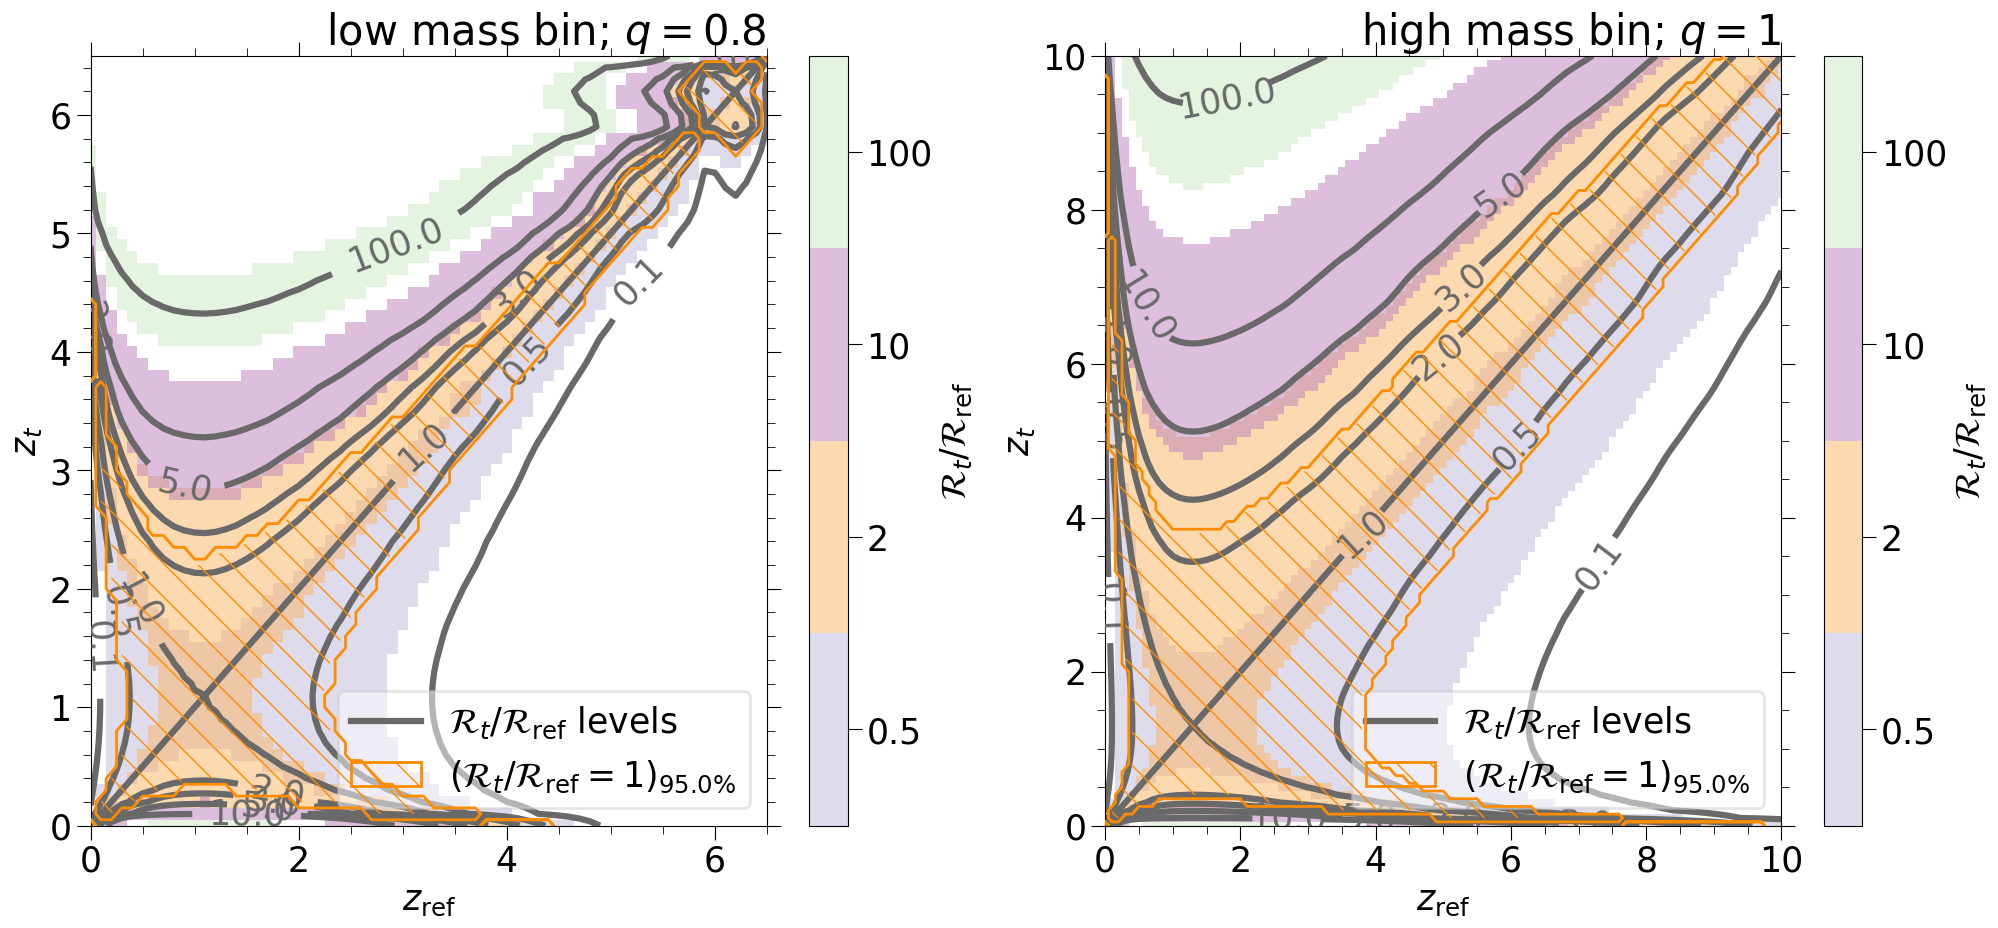

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(rf'{mlb[key]}; $q = {q[key]}$', loc='right')

    ax.set_xlabel(rf'${zref_lb}$')
    ax.set_ylabel(rf'${zt_lb}$')

    # R1/R2 color map
    cmap = plt.colormaps['Set3'].resampled(len(R1_R2_ref_list))
    cmap = ListedColormap(cmap.colors)
    _alpha = 0.5

    only_these_R1_R2 = [0.5, 2, 10, 100]
    color_indexes = []
    for i, (Det_map, lb) in enumerate(zip(Det_ZZmap_R1_R2_list[key], R1_R2_ref_list)):
        if len(only_these_R1_R2) == 0:
            im = ax.pcolormesh(zinf_axis[key], zinf_axis[key], Det_map.T,
                               cmap=ListedColormap([cmap.colors[i]]), alpha=_alpha)
        elif lb in only_these_R1_R2:
            im = ax.pcolormesh(zinf_axis[key], zinf_axis[key], Det_map.T,
                               cmap=ListedColormap([cmap.colors[i]]), alpha=_alpha)
            color_indexes.append(i)
    
    lines = []
    # R1/R2 Contour levels
    levels = [0.1, 0.5, 1, 2, 3, 5, 10, 100]
    cf = ax.contour(zinf_axis[key], zinf_axis[key], R1_R2_CI_ZZarray[key][:, :, 1].T,
                    levels=levels, colors=lvl_color)
    lines.append(ax.plot([], [], color=lvl_color, label=rf'${Rratio_lb}$ levels')[0]) # Proxy for legend
    ax.clabel(cf)

    # Plot the confidence interval for R2/R2 = 1
    # Select the boundary using binary erosion
    kernel = np.ones((3, 3), dtype=int)
    kernel[0, 0], kernel[0, 2], kernel[2, 0], kernel[2, 2] = 0, 0, 0, 0
    intern = binary_erosion(Det_ZZmap_R1_R2_list[key][R1_R2_ref_list.index(R1_R2_ref)], structure=kernel).astype(Det_ZZmap_R1_R2_list[key][R1_R2_ref_list.index(R1_R2_ref)].dtype)
    boundary = Det_ZZmap_R1_R2_list[key][R1_R2_ref_list.index(R1_R2_ref)] - intern
    ZZref, ZZt = np.meshgrid(zinf_axis[key], zinf_axis[key])
    # Plot hacthes using contourf
    defualt_hatch_color = plt.rcParams['hatch.color']
    plt.rcParams['hatch.color'] = ref_lvl_color
    ax.contourf(zinf_axis[key], zinf_axis[key], Det_ZZmap_R1_R2_list[key][R1_R2_ref_list.index(R1_R2_ref)].T,
                levels=[0.5, 1.5], colors='none', hatches='\\', zorder=100)
    plt.rcParams['hatch.color'] = defualt_hatch_color
    # Plot contour using contour
    ax.contour(np.pad(zinf_axis[key], pad_width=1, mode='constant', constant_values=(np.min(zinf_axis[key]) + zw[key], np.max(zinf_axis[key]) + zw[key])),
               np.pad(zinf_axis[key], pad_width=1, mode='constant', constant_values=(np.min(zinf_axis[key]) + zw[key], np.max(zinf_axis[key]) + zw[key])),
               np.pad(Det_ZZmap_R1_R2_list[key][R1_R2_ref_list.index(R1_R2_ref)].T, pad_width=1, mode='constant', constant_values=0),
               levels=[0.5], colors=ref_lvl_color, linewidths=plt.rcParams['patch.linewidth'], zorder=100)
    # Use the boundary to set the plot limits
    ax.set_xlim(np.min(zinf_axis[key]), np.max(ZZref[boundary == 1]))
    ax.set_ylim(np.min(zinf_axis[key]), np.max(ZZt[boundary == 1]))
    # Proxy for legend
    lines.append(ax.fill_between([], [], [], color=ref_lvl_color, facecolor='none', hatch='\\', label=rf'$({Rratio_lb} = {R1_R2_ref})_{{{cl * 100}\%}}$'))
    
    # Define the boundaries of each colors using equal spacing
    if len(only_these_R1_R2) == 0:
        boundaries = np.arange(len(R1_R2_ref_list) + 1)
    else:
        boundaries = np.arange(len(only_these_R1_R2) + 1)
        cmap = ListedColormap([cmap.colors[i] for i in color_indexes])
    # Associate to each color bin its color using a BoundaryNorm, the cmap and the ScalarMappable
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
    sm = ScalarMappable(norm, cmap)
    # Define each tick location in the middle of each color bin
    tick_locs = boundaries[:-1] + 0.5
    # Create the colorbar with our cmap and the ticks locations
    cbar = fig.colorbar(sm, ax=ax, label=rf'${Rratio_lb}$', ticks=tick_locs)
    # Now set the labels
    if len(only_these_R1_R2) == 0:
        cbar.ax.get_yaxis().set_ticklabels(labels=R1_R2_ref_list)
    else:
        cbar.ax.get_yaxis().set_ticklabels(labels=only_these_R1_R2)
    cbar.ax.get_yaxis().set_minor_locator(mpl.ticker.NullLocator())
    # This is the only way I found to set the colorbar transparency
    cbar.solids.set_alpha(_alpha)

    ax.legend(handles=lines, loc='lower right')

figures.append(fig)
figure_paths.append(os.path.join(image_path, "zt_zref_detmap"))

plt.show()

In [20]:
if save_fig:
    for fig, path in zip(figures, figure_paths):
        fig.savefig(path)
    
    figures, figure_paths = [], []